In [18]:
library(tidyverse)
library(qusage)
library(destiny)
library(princurve)
library(scatterplot3d)
library(slingshot)
library(viridis)
library(BiocParallel)
library(grid)
library(gplots)
library(SingleCellExperiment)
library(Seurat)
library(DelayedMatrixStats)


source("/storage/coda1/p-ggibson3/0/mduan31/rich_project_bio-gibson/public_code/dotplot_mmnorm.R")
source("/storage/coda1/p-ggibson3/0/mduan31/rich_project_bio-gibson/public_code/seurat_visualization.R")

Loading required package: DelayedArray


Attaching package: ‘DelayedArray’


The following object is masked from ‘package:BiocGenerics’:

    aperm


The following object is masked from ‘package:igraph’:

    simplify


The following object is masked from ‘package:purrr’:

    simplify


The following objects are masked from ‘package:base’:

    aperm, apply, rowsum, scale, sweep



Attaching package: ‘DelayedMatrixStats’


The following objects are masked from ‘package:matrixStats’:

    colAnyMissings, rowAnyMissings




In [5]:
pc = readRDS("BMPC_SeuratObj.rds")
dim(pc)
names(pc)

[1] 18727 17347

[1] "RNA"        "SCT"        "integrated" "umap"

### Code for Main Figure 2 

- Figure 2A & B: slingshot inferred BMPC maturation paths <br>


### run slingshot to infer the BMPC maturation trajectories and pseudotime of the cells along the maturation path

In [99]:
### Removing IgM cell clusters and cluster 12 (potential cells primed for apoptosis)
Idents(pc) = pc$cluster_id
pc.mito = subset(pc,idents = c(12,13,14,15),invert = TRUE)
deg.union1 = unlist(deg.union1)
## Figure 3A: UMAP trajectory
## In script Celia_trajectory_running.R
sds2 <- slingshot(Embeddings(pc.mito,"umap"),clusterLabels = pc.mito$cluster_id,
                  start.clus = "1")#end.clus = c("ImmB","ProB-sub2","MEP+E","Mono")
lineages <- slingLineages(sds2)
lineage_ctrl <- slingParams(sds2)
cluster_network <- lineages %>%
  map_df(~ tibble(from = .[-length(.)], to = .[-1])) %>%
  unique() %>%
  mutate(
    length = lineage_ctrl$dist[cbind(from, to)],
    directed = TRUE)
dimred <- Embeddings(pc.mito,"umap")

lin1 <- getLineages(sds2, clusterLabels = pc.mito$cluster_id, start.clus = '1')

## Figure 3B:
# combined curve 3 and curve 5 as "Path3"
pt = slingPseudotime(sds2)
pt = as.data.frame(pt)
pt$path3 = apply(pt[,c(3,5)],1,function(x) mean(x,na.rm = TRUE))
names(pt) = c("Path2","Path1","curve3","Path4","curve5","Path3")

pt$cluster_id = pc$cluster_id[which(!pc$cluster_id %in% c(12:15))]

### Figure 2A: UMAP and cell maturation paths

In [118]:
curves = getCurves(lin1)

In [139]:
## build color scales for each cell cluster
color <- data.frame(cell_color = c("#67000D", "#EF3A24", "#F08621",  "#E1B71C","#BCD3DF",
                          "#213558", "#32B2BF","#018AC0","#807DBA","#6A51A3",
                          "#54278F"),cluster_id = factor(c(1:11)))
head(color)
cell_color <- pc.mito@meta.data %>% select(cluster_id) %>% left_join(color)
head(cell_color)

,cell_color,cluster_id
,<chr>,<fct>
1,#67000D,1
2,#EF3A24,2
3,#F08621,3
4,#E1B71C,4
5,#BCD3DF,5
6,#213558,6


Joining with `by = join_by(cluster_id)`


,cluster_id,cell_color
,<fct>,<chr>
1,2,#EF3A24
2,3,#F08621
3,3,#F08621
4,4,#E1B71C
5,7,#32B2BF
6,7,#32B2BF


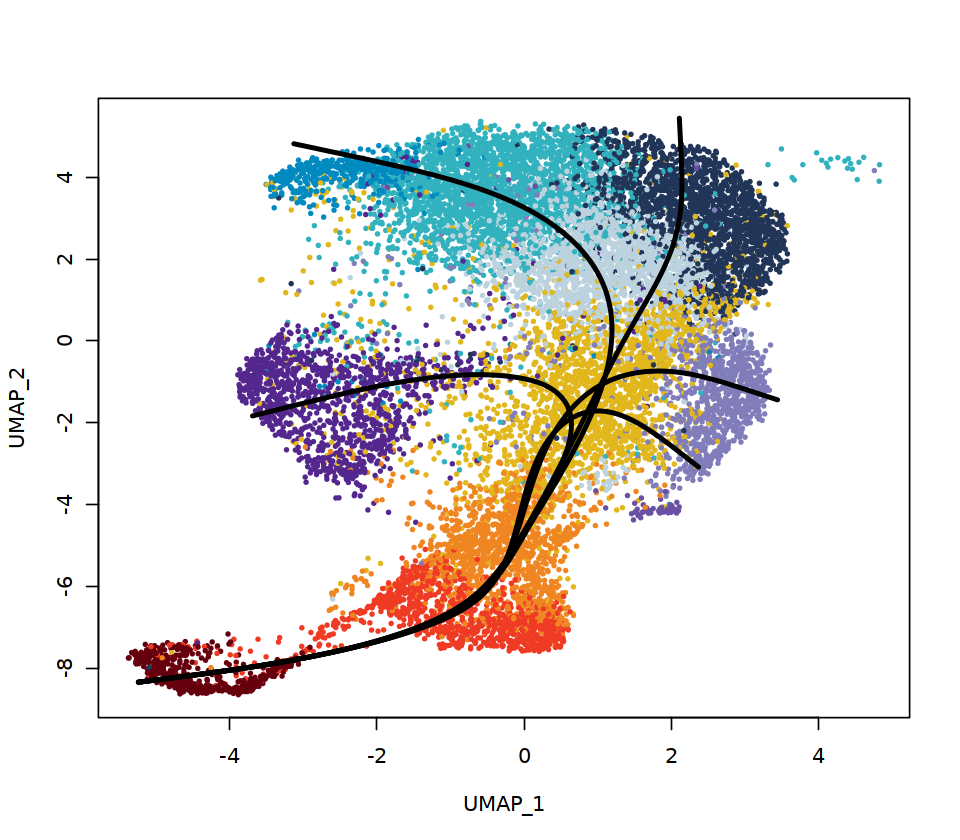

In [142]:
options(repr.plot.width=8, repr.plot.height=7)
plot(dimred,col = cell_color$cell_color, pch = 16, cex = 0.5) 
#lines(sds2, col = "darkgreen",asp = 1, pch = 16,add = TRUE)
lines(SlingshotDataSet(curves), lwd = 3, col = 'black')


### Figure 2B: Split maturation path and corresponding cell density plots

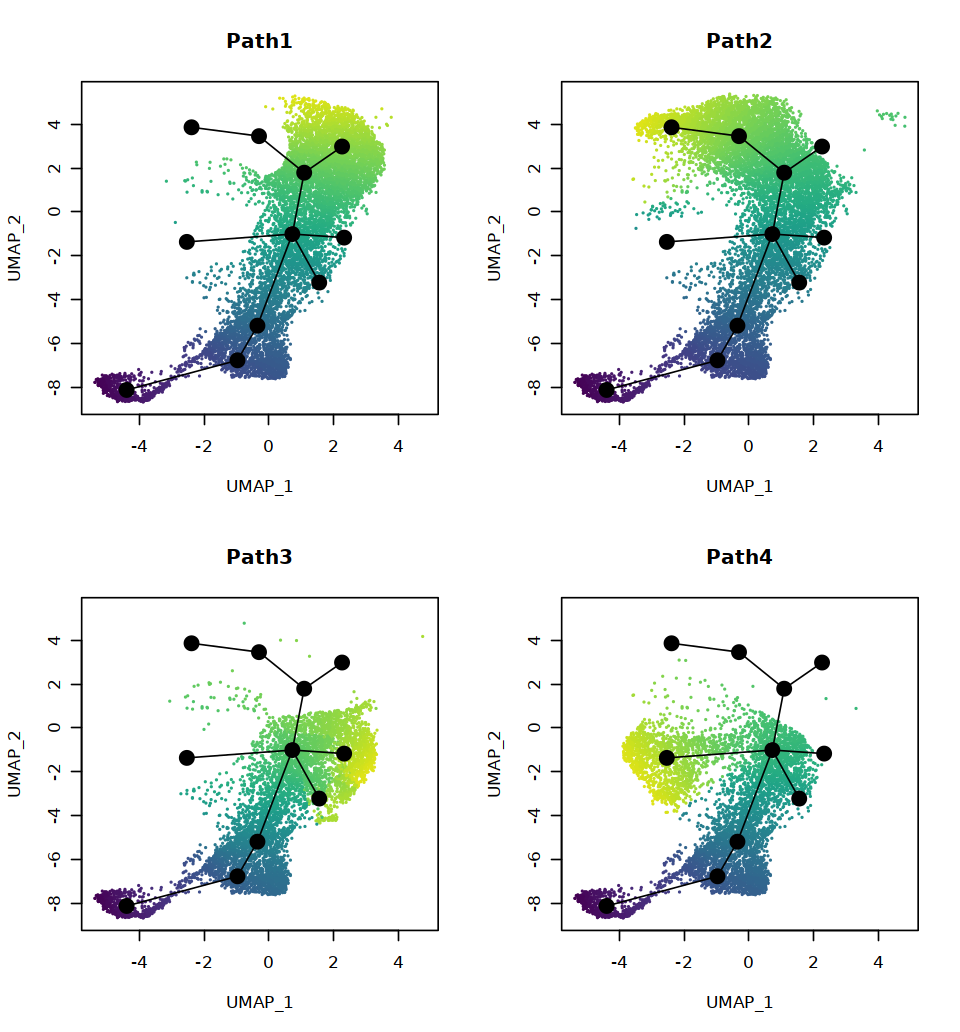

In [151]:
options(repr.plot.width=8, repr.plot.height=8.6)
pal <- viridis(100, end = 0.95)
nms = c("Path1","Path2","Path3","Path4")
par(mfrow = c(2, 2))
for (i in nms) {
  colors <- pal[cut(pt[,i], breaks = 100)]
  plot(dimred, col = colors, pch = 16, cex = 0.3, main = i)
  lines(SlingshotDataSet(curves), lwd = 1, col = 'black', type = 'lineages')
}

In [109]:
head(pt)

,Path2,Path1,curve3,Path4,curve5,Path3,cluster_id
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
CLS028-popA_AAACGGGCACGCCAGT-1,4.585088,4.580067,4.561602,4.556355,4.556823,4.559213,2
CLS028-popA_AAACGGGCACTTACGA-1,5.458693,5.450462,5.458748,5.482850,5.453083,5.455915,3
CLS028-popA_AAAGATGAGTGATCGG-1,4.718570,4.723152,4.744558,4.738889,4.754365,4.749461,3
CLS028-popA_AAAGCAAAGCGTAATA-1,10.753262,10.819235,11.325509,10.203028,10.477460,10.901485,4
CLS028-popA_AAAGCAACAAACTGTC-1,15.401118,NA,NA,NA,NA,NaN,7
CLS028-popA_AAAGTAGAGTTGAGTA-1,16.833859,NA,NA,NA,NA,NaN,7


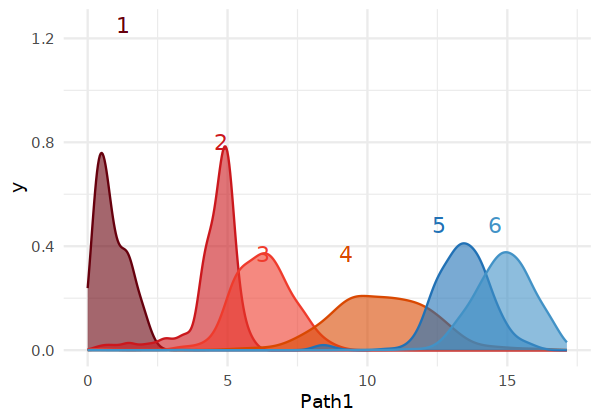

In [104]:
## density plot for Path1
options(repr.plot.width=5, repr.plot.height=3.5)
# count cells in each cell type in each curve
cnt <- pt %>% filter(!is.na(Path1)) %>%
  group_by(cluster_id) %>%
  tally

# get names of the species with counts >= 10
freq_cnt <-  cnt %>%
  filter(n >= 150) %>%
  select(cluster_id)

annot <- data.frame(
  cluster_id= c("1", "2", "3", "4","5","6"),
  x = c(1, 4.5, 6, 9,12.3,14.3),
  y = c(1.25, 0.8, 0.37, 0.37,0.48,0.48)
)

# filter out the less-frequent species

pt %>% filter(!is.na(Path1)) %>%
  filter(cluster_id %in% freq_cnt$cluster_id) %>%
  ggplot(aes(x=Path1, group=cluster_id, fill=cluster_id,color = cluster_id)) +
  geom_density(adjust=1.5, alpha=.6) + 
  scale_fill_manual(values = c("#67000D", "#CB181D", "#EF3B2C", "#D94801","#2171B5", 
                               "#4292C6"))+
  scale_color_manual(values = c("#67000D", "#CB181D", "#EF3B2C", "#D94801","#2171B5", 
                                "#4292C6"))+
  geom_text( data=annot, aes(x=x, y=y, label=cluster_id), hjust=0, size=4.5) +
  theme_minimal()+
  theme(legend.position = "none")

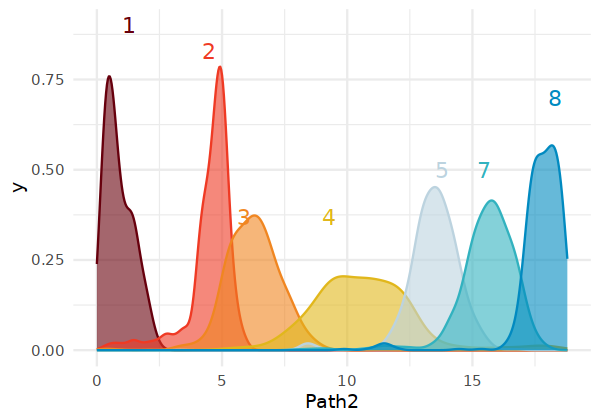

In [112]:
## density plot for Path2
options(repr.plot.width=5, repr.plot.height=3.5)
# count cells in each cell type in each curve
cnt <- pt %>% filter(!is.na(Path2)) %>%
  group_by(cluster_id) %>%
  tally

# get names of the species with counts >= 100
freq_cnt <-  cnt %>%
  filter(n >= 100) %>%
  select(cluster_id)

annot <- data.frame(
  cluster_id= c("1", "2", "3", "4","5","7","8"),
  x = c(1, 4.2, 5.6, 9,13.5,15.2,18),
  y = c(0.9, 0.83, 0.37, 0.37,0.5,0.5,0.7)
)

pt %>% filter(!is.na(Path2)) %>%
  filter(cluster_id %in% freq_cnt$cluster_id) %>%
  ggplot(aes(x=Path2, group=cluster_id, fill=cluster_id,color = cluster_id)) +
  geom_density(adjust=1.5, alpha=.6) + 
  scale_fill_manual(values = c("#67000D", "#EF3A24", "#F08621",  "#E1B71C","#BCD3DF","#32B2BF","#018AC0"))+
  scale_color_manual(values = c("#67000D", "#EF3A24", "#F08621",  "#E1B71C","#BCD3DF","#32B2BF","#018AC0"))+
  geom_text( data=annot, aes(x=x, y=y, label=cluster_id), hjust=0, size=4.5) +
  theme_minimal()+
  theme(legend.position = "none")

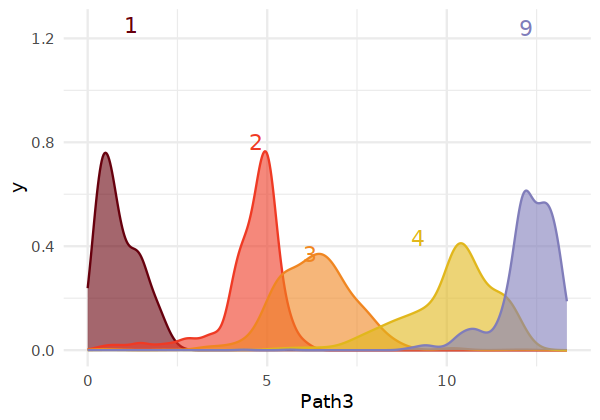

In [114]:
## density plot for Path3
# count cells in each cell type in each curve
cnt <- pt %>% filter(!is.na(Path3)) %>%
  group_by(cluster_id) %>%
  tally

# get names of the species with counts >= 10
freq_cnt <-  cnt %>%
  filter(n >= 100) %>%
  select(cluster_id)

annot <- data.frame(
  cluster_id= c("1", "2", "3", "4","9"),
  x = c(1, 4.5, 6, 9,12),
  y = c(1.25, 0.8, 0.37, 0.43,1.24)
)

# filter out the less-frequent species

pt %>% filter(!is.na(Path3)) %>%
  filter(cluster_id %in% freq_cnt$cluster_id) %>%
  ggplot(aes(x=Path3, group=cluster_id, fill=cluster_id,color = cluster_id)) +
  geom_density(adjust=1.5, alpha=.6) + 
  scale_fill_manual(values = c("#67000D", "#EF3A24", "#F08621",  "#E1B71C","#807DBA"))+
  scale_color_manual(values = c("#67000D", "#EF3A24", "#F08621",  "#E1B71C","#807DBA"))+
  geom_text( data=annot, aes(x=x, y=y, label=cluster_id), hjust=0, size=4.5) +
  theme_minimal()+
  theme(legend.position = "none")

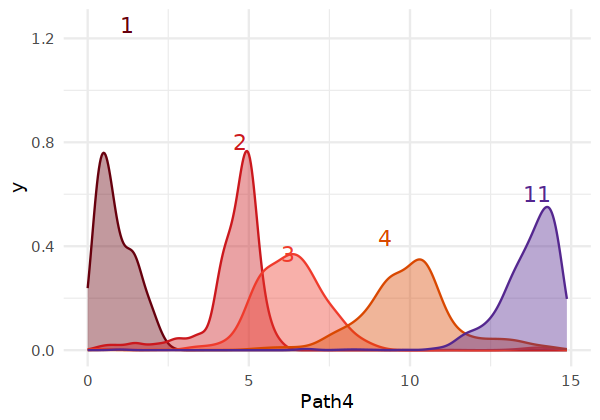

In [116]:
## Path4
# count cells in each cell type in each curve
cnt <- pt %>% filter(!is.na(Path4)) %>%
  group_by(cluster_id) %>%
  tally

# get names of the species with counts >= 10
freq_cnt <-  cnt %>%
  filter(n >= 100) %>%
  select(cluster_id)

annot <- data.frame(
  cluster_id= c("1", "2", "3", "4","11"),
  x = c(1, 4.5, 6, 9,13.5),
  y = c(1.25, 0.8, 0.37, 0.43,0.6)
)

# filter out the less-frequent species

pt %>% filter(!is.na(Path4)) %>%
  filter(cluster_id %in% freq_cnt$cluster_id) %>%
  ggplot(aes(x=Path4, group=cluster_id, fill=cluster_id,color = cluster_id)) +
  geom_density(adjust=1.5, alpha=.4) + 
  scale_fill_manual(values = c("#67000D", "#CB181D", "#EF3B2C", "#D94801","#54278F"))+
  scale_color_manual(values = c("#67000D", "#CB181D", "#EF3B2C", "#D94801","#54278F"))+
  geom_text( data=annot, aes(x=x, y=y, label=cluster_id), hjust=0, size=4.5) +
  theme_minimal()+
  theme(legend.position = "none")

### Figure 2C: Calculating hallmark enrichment score using DEGs by comparing adjacent BMPC clusters, and early and late BMPC clusters

In [152]:
## building a dataframe to store both umap cell embeddings and calculated HALLMARK pathway enrichment scores
data_df = as.data.frame(pc[["umap"]]@cell.embeddings)


load Gene sets from msigdb hallmark and GO database; For the version information, please check our manuscript.

In [153]:
load("Annotation_GeneSet_List.RData")

In [154]:
## load merged DEG lists
load("MAST_DEG.RData")
ls()
## Getting rid of proliferative cell related DEGs
deg.union1 = c()
for(i in names(mast.deg)[-c(4,5)]){
  deg.union1 = union(deg.union1,row.names(mast.deg[[i]]))
}

[1] "annot"                               "build_seurat_obj"                   
 [3] "build_SeuratObj"                     "cell_color"                         
 [5] "cell_colors"                         "cell_pal"                           
 [7] "cell.color"                          "cell.color1"                        
 [9] "celltype_prop_vis"                   "celltype_prop_vis_with_significance"
[11] "cluster_network"                     "cnt"                                
[13] "color"                               "colors"                             
[15] "colorTNK"                            "composition_bar"                    
[17] "create.vizgen.fov"                   "create.vizgen.obj"                  
[19] "crv1"                                "curves"                             
[21] "data_df"                             "define_region"                      
[23] "deg.union1"                          "dimplot"                            
[25] "dimred"                              "dotplot"                            
[27] "fig.2d"                              "fig2d"                              
[29] "fig3"                                "fig3c"                              
[31] "fig3c.scl"                           "fig4e"                              
[33] "fig6c.data"                          "figs6c"                             
[35] "Figure.org"                          "freq_cnt"                           
[37] "genelist"                            "GeneSet"                            
[39] "hist"                                "i"                                  
[41] "Ig.cut"                              "image.dimplot"                      
[43] "image.featureplot"                   "int_gene"                           
[45] "lin1"                                "lineage_ctrl"                       
[47] "lineages"                            "marker.gene"                        
[49] "maxnorm"                             "mito.cut"                           
[51] "mmnorm"                              "mycol"                              
[53] "mycolor"                             "nGene.alt"                          
[55] "nGene.lower"                         "nGene.upper"                        
[57] "nms"                                 "nUMI.lower"                         
[59] "nUMI.upper"                          "p"                                  
[61] "pair.color"                          "pal"                                
[63] "pc"                                  "pc_ident"                           
[65] "pc.filt.combined"                    "pc.mito"                            
[67] "PercentAbove"                        "pie_chart"                          
[69] "plot_lineages"                       "pt"                                 
[71] "sds2"                                "seurat_cluster"                     
[73] "seurat_integration"                  "seurat.dimplot"                     
[75] "seurat.dotplot"                      "seurat.featureplot"                 
[77] "stackVlnplot"                        "t.marker"                           
[79] "upset_plot"                          "vizgen.cell.qc"                     
[81] "vizgen.celltype.subset"              "vizgen.cluster"                     
[83] "vizgen.diagnostic.plots"             "vizgen.hist"                        
[85] "vizgen.normalize"                    "VlnBoxplot"

In [156]:
## Figure 2C
### Calculating enrichment score for Hallmark pathways using DEGs
Hindex = which(grepl("^HALLMARK_",names(GeneSet)))
Hfile = data.frame("Pathway" = names(GeneSet)[Hindex],"Associated_DEGs" = "TBD")
Hfile$Associated_DEGs = as.character(Hfile$Associated_DEGs)
row.names(Hfile) = names(GeneSet)[Hindex]

# 1. calculating Hallmark enrichment score (ES) in each cell
Hcell = matrix(0,nrow = nrow(pt),ncol = 50)
colnames(Hcell) = names(GeneSet)[Hindex]
row.names(Hcell) = row.names(pt)

geneset.selected = names(GeneSet)[Hindex]
for(j in geneset.selected) {

  temp = intersect(deg.union1,GeneSet[[j]])
  #Hfile[j,"Associated_DEGs"] = paste0(temp,collapse = ",")
  
  
  #filter for GSEA genes
  if(length(temp)>1){
    score = pc[["RNA"]]@data[which(row.names(pc[["RNA"]]@data) %in% temp),row.names(pt)]
    score = as.matrix(score)
    score.mean = colMeans(score)
    
    Hcell[,j] = score.mean
  }
  
}

# 2. combined slingshot inferred pseudotime with hallmark ES
pt = pt[,c(1:6)]
pt$cluster_id = pc.mito$cluster_id
pt = cbind(pt,Hcell)

## parameters setting 
cell_size=0.5
cell_name_size=2
x = 1
y = 2
colors = c("#ffffcc", "#ffeda0", "#ffeda0", "#fed976", "#feb24c", "#fc4e2a", "#bd0026", "#800026")

# 3. adding pathway names and corresponding enriched DEGs
Hindex = which(grepl("^HALLMARK_",names(GeneSet)))
Hfile = data.frame("Pathway" = names(GeneSet)[Hindex],"Associated_DEGs" = "TBD")
Hfile$Associated_DEGs = as.character(Hfile$Associated_DEGs)
row.names(Hfile) = names(GeneSet)[Hindex]

Have = matrix(0,nrow = nrow(Hfile),ncol = 15)
row.names(Have) = names(GeneSet)[Hindex]
colnames(Have) = levels(pc$cluster_id)

geneset.selected = names(GeneSet)[Hindex]
for(j in geneset.selected) {
  
  temp = intersect(deg.union1,GeneSet[[j]])
  Hfile[j,"Associated_DEGs"] = paste0(temp,collapse = ",")
  
  
  #filter for GSEA genes
  if(length(temp)>1){
    score = pc[["RNA"]]@data[which(row.names(pc[["RNA"]]@data) %in% temp),]
    score = as.matrix(score)
    score.mean = as.data.frame(colMeans(score))
    score.mean$cluster_id = pc$cluster_id
    names(score.mean) = c("Mean","Celltype")
    cluster_id.mean = aggregate(Mean ~ Celltype,data = score.mean,FUN = mean)
    Have[j,] = t(cluster_id.mean$Mean)
    color_by = score.mean$Mean
  }
}

Hscore = cbind(Hfile,Have)

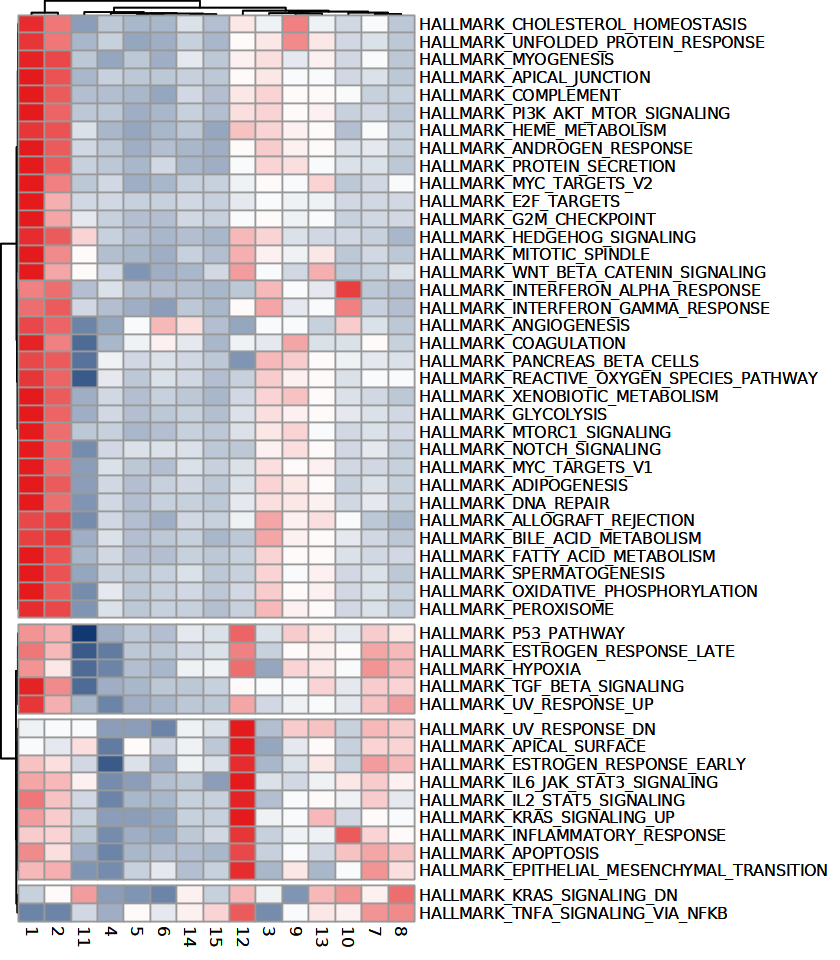

In [165]:
## Supplementary Figure S5A
bk = unique(c(seq(-2.5,2.5,length = 50)))
options(repr.plot.width=7, repr.plot.height=8)
out <- pheatmap(Hscore[,c(3:17)],breaks = bk,color = colorRampPalette(c("#08306B","white","#E41A1C"))(50),
                cluster_rows = T,clustering_distance_rows = "correlation",clustering_method = "ward.D", 
                cluster_cols = T,clustering_distance_cols = "euclidean",
                show_colnames = TRUE,show_rownames = TRUE,fontsize_row = 9,annotation_names_row = FALSE,
                scale = "row",cutree_rows =4,treeheight_row = 6,treeheight_col = 4,legend = FALSE)
out

Because we only inferred BMPC maturation paths in IgG dominant cell populations, in the main figure 3C, we only visualized the gene enrichment score in IgG cell clusters, cluster 1 to 11. But we inherited hierarchical row clustering results from the above plot.

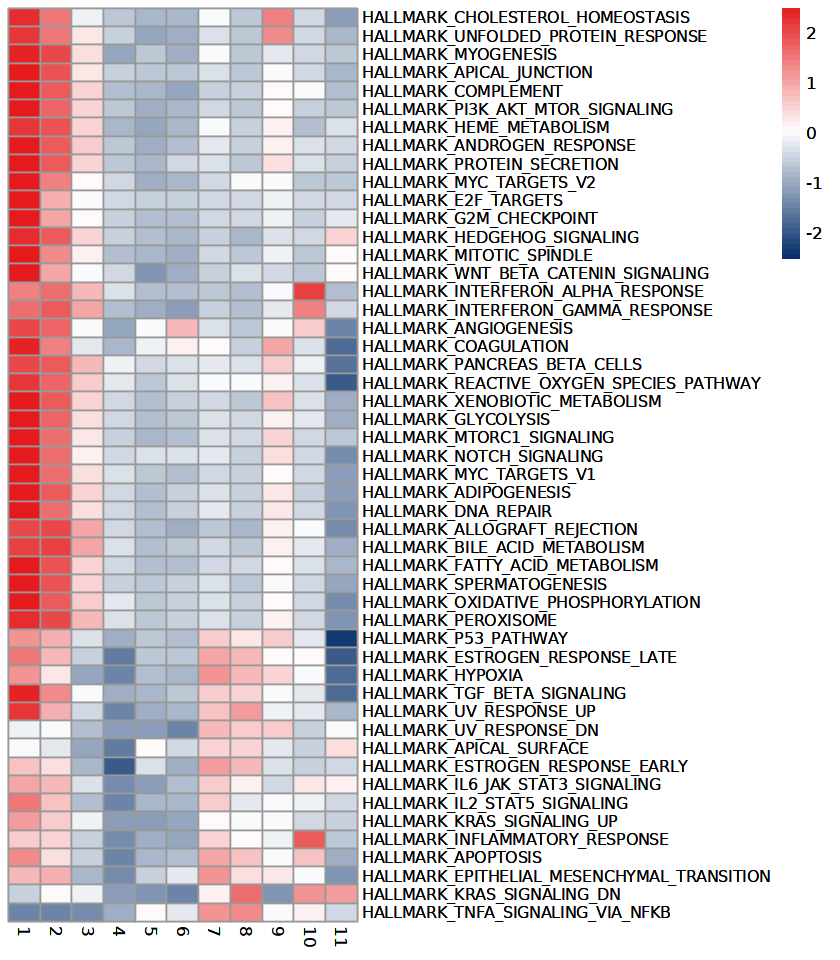

In [167]:
## Figure 2C
fig3c = Hscore[,c(3:17)]
fig3c.scl = t(apply(fig3c,1,scale))
colnames(fig3c.scl) = colnames(fig3c)
gg <- cutree(out$tree_row, k=4)[out$tree_row[["order"]]]

p <- pheatmap(fig3c.scl[names(gg),c(1:11)],breaks = bk,color = colorRampPalette(c("#08306B","white","#E41A1C"))(50),
              cluster_rows = F,cluster_cols = F,
              show_colnames = TRUE,show_rownames = T,fontsize_row = 9,annotation_names_row = FALSE,
              legend = T)

p

[1] "HALLMARK_FATTY_ACID_METABOLISM"
[1] "HALLMARK_P53_PATHWAY"
[1] "HALLMARK_INFLAMMATORY_RESPONSE"
[1] "HALLMARK_TNFA_SIGNALING_VIA_NFKB"


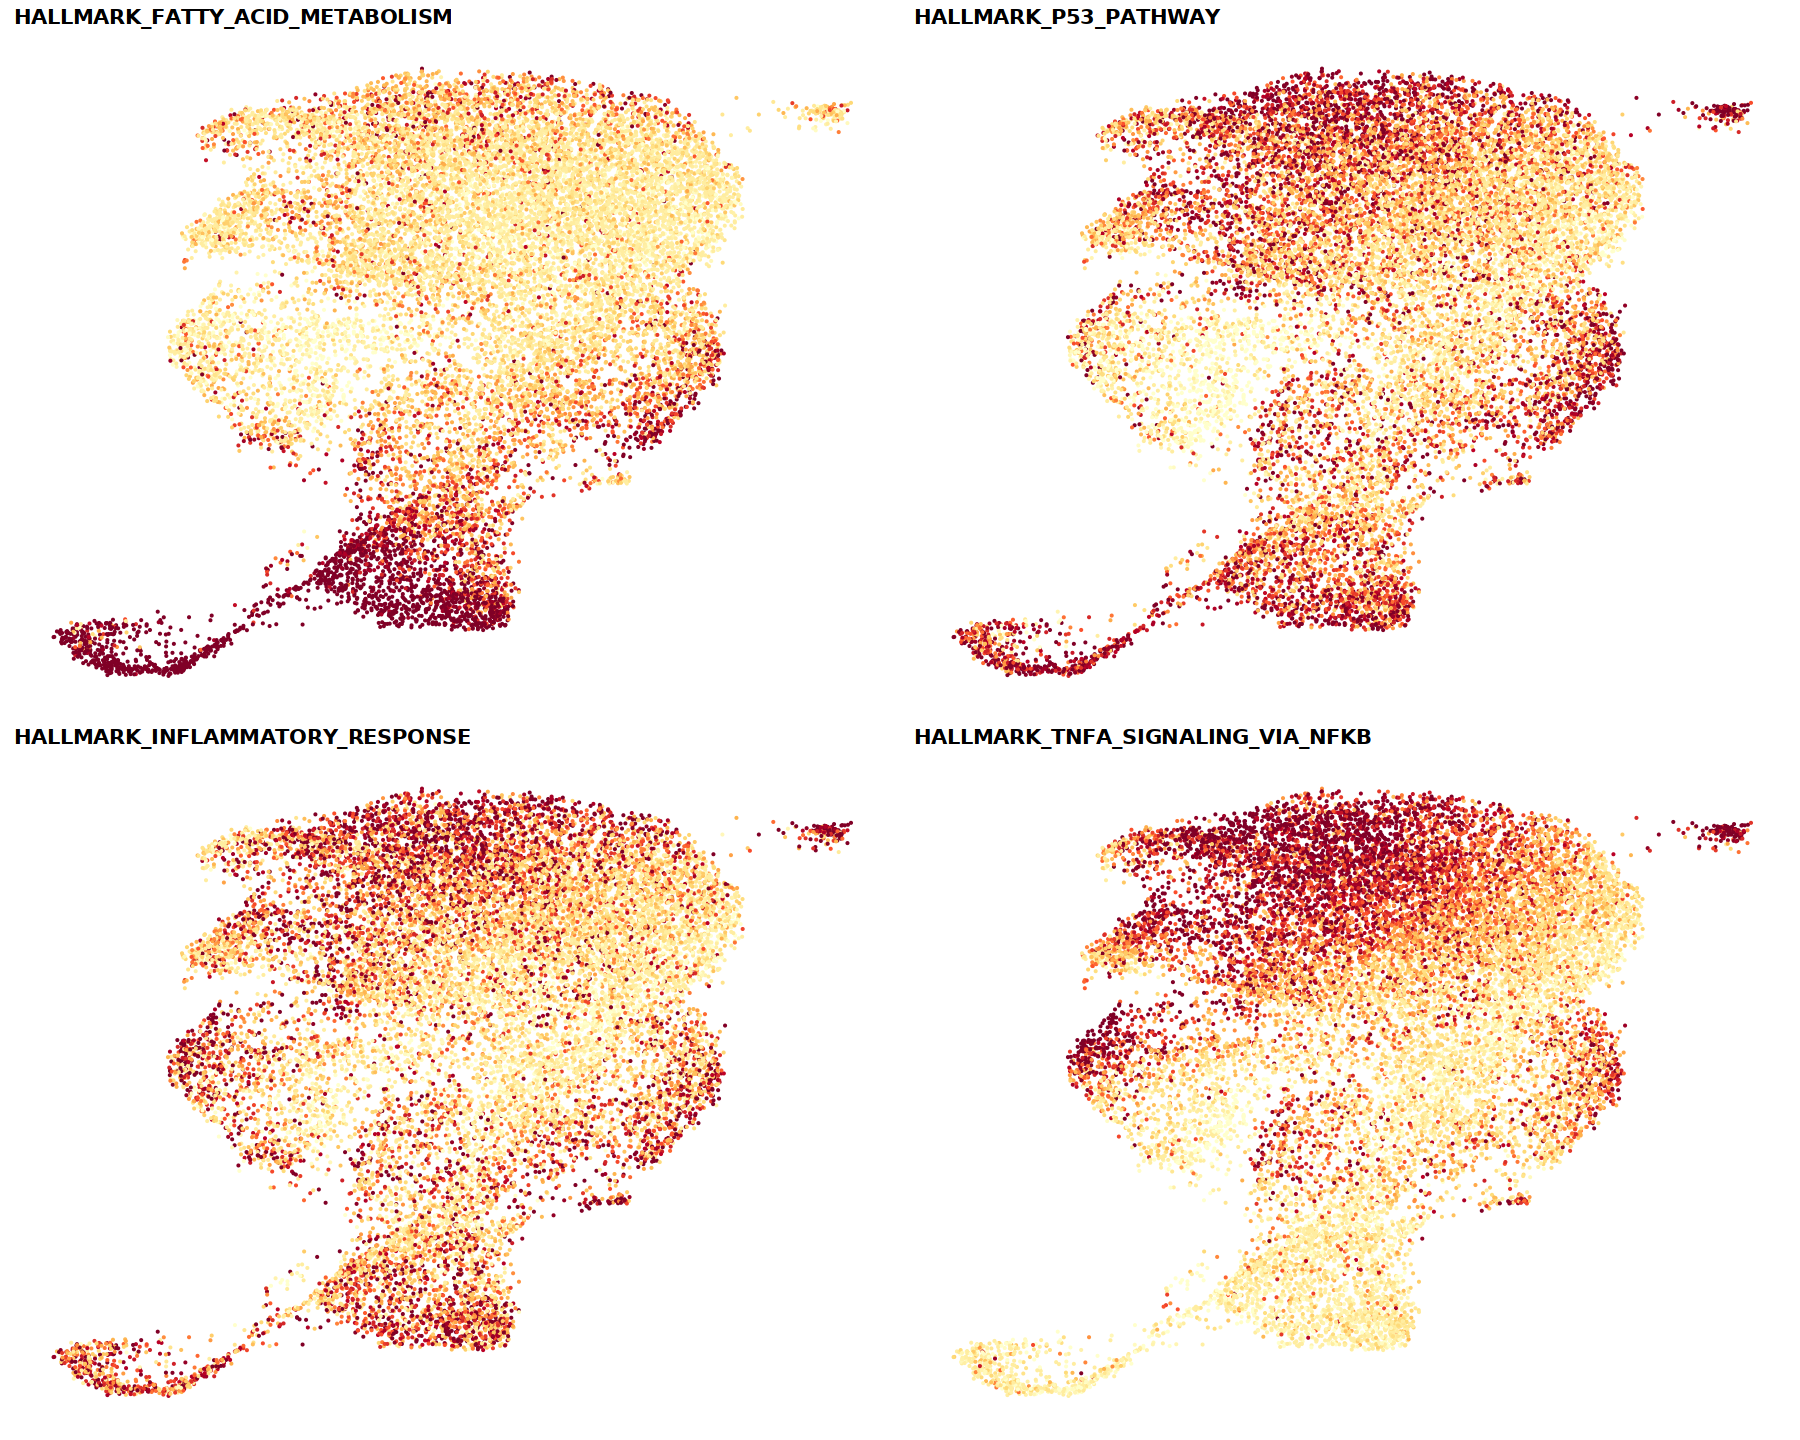

In [183]:
## Figure 2D
## Project selected pathways on UMAP
geneset4vis = c('HALLMARK_FATTY_ACID_METABOLISM','HALLMARK_P53_PATHWAY','HALLMARK_INFLAMMATORY_RESPONSE','HALLMARK_TNFA_SIGNALING_VIA_NFKB')

ppi = 500
graph_ncol = 2
colors = c("#ffffcc", "#ffeda0", "#ffeda0", "#fed976", "#feb24c", "#fc4e2a", "#bd0026", "#800026") 
define_region <- function(row, col){
  viewport(layout.pos.row = row, layout.pos.col = col)
} 

options(repr.plot.width=15, repr.plot.height=12)
grid.newpage()
pushViewport(viewport(layout = grid.layout(nrow = ceiling(length(geneset4vis)/graph_ncol), ncol=graph_ncol)))
index = 1
for(j in geneset4vis) {
  print(j)
  temp = intersect(deg.union1,GeneSet[[j]])
  
  if(index %% graph_ncol ==0){
      col_index = graph_ncol
  }else{
      col_index = index %% graph_ncol
  }
  row_index = ceiling(index/graph_ncol)
    
  #filter for GSEA genes
  if(length(temp)>1){
    score = pc[["RNA"]]@data[which(row.names(pc[["RNA"]]@data) %in% temp),]
    score = as.matrix(score)
    score.mean = as.data.frame(colMeans(score))
    score.mean$cluster_id = pc$cluster_id
    names(score.mean) = c("Mean","Celltype")
    cluster_id.mean = aggregate(Mean ~ Celltype,data = score.mean,FUN = mean)
    color_by = score.mean$Mean
  }
  
  # if(max(score.mean) <1){
  #   color_by = score.mean
  # }else{
  #   color_by = score.mean^3
  # }
  
  g <- ggplot(data=data_df, aes(x=UMAP_1, y=UMAP_2))
  g <- g + geom_point(aes(color = color_by), size=I(0.1), na.rm = TRUE) 
  g <- g +
    scale_colour_gradientn(colors=colors, limits = c(quantile(color_by, .05),quantile(color_by, .9)), oob = scales::squish)
  g <- g +
    theme(axis.line=element_blank(),axis.text.x=element_blank(),axis.text.y=element_blank(), axis.ticks=element_blank(),
          axis.title.x=element_blank(),axis.title.y=element_blank(),panel.background=element_blank(),
          panel.border=element_blank(),panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
          plot.background=element_blank(),plot.title = element_text(size=12,face = "bold"),legend.position = "none")  
  g <- g+ ggtitle(j)
  print(g,vp = define_region(row = row_index, col = col_index))
  index = index+1

}

**Figure 2E: Scatter plot with fitting line**

`geom_smooth()` using formula = 'y ~ x'


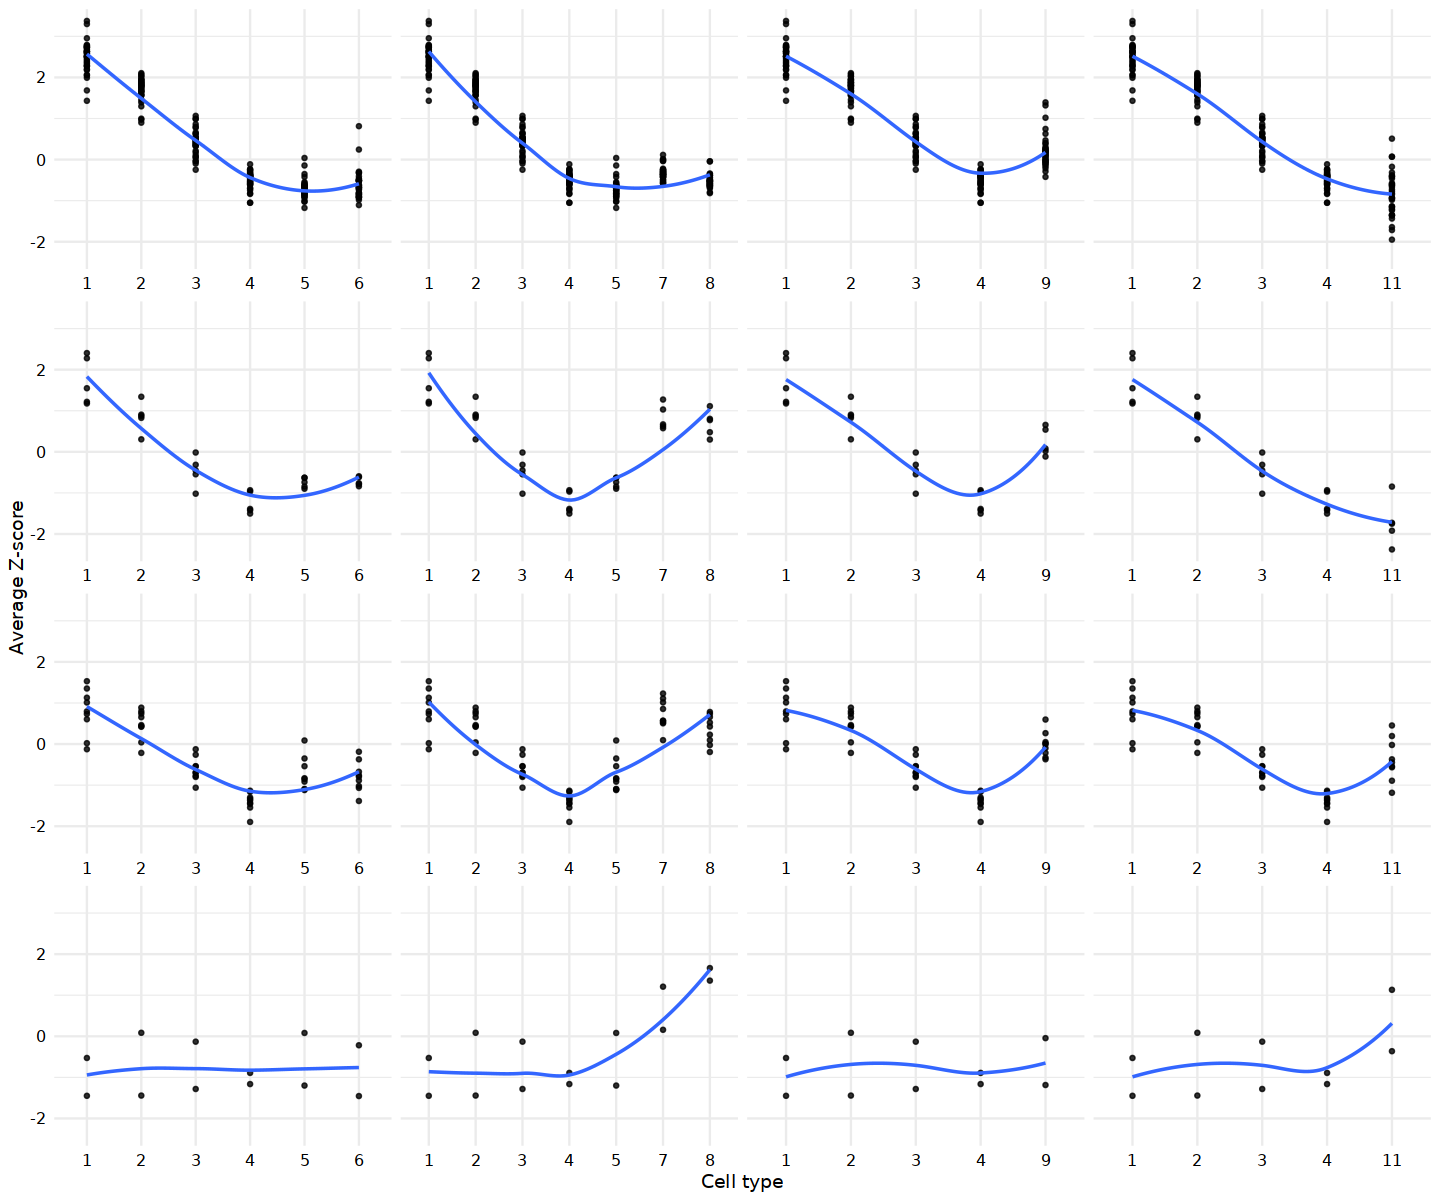

In [185]:
## scatter plot with fitting line
## Because every path contains different cell clusters, we will calculate enrichment score of each pathway in each path individually.

## path1
temp = fig3c.scl[names(gg),c(1:6)]
temp = as.data.frame(temp)
temp$pathway = row.names(temp)
temp$pattern = gg
temp4plot = melt(temp,id = c("pathway","pattern"))
temp4plot$pattern = factor(temp4plot$pattern)

## path2
temp = fig3c.scl[names(gg),c(1:5,7,8)]
temp = as.data.frame(temp)
temp$pathway = row.names(temp)
temp$pattern = gg
temp4plot2 = melt(temp,id = c("pathway","pattern"))

## path3
temp = fig3c.scl[names(gg),c(1:4,9)]
temp = as.data.frame(temp)
temp$pathway = row.names(temp)
temp$pattern = gg
temp4plot3 = melt(temp,id = c("pathway","pattern"))

## path4
temp = fig3c.scl[names(gg),c(1:4,11)]
temp = as.data.frame(temp)
temp$pathway = row.names(temp)
temp$pattern = gg
temp4plot4 = melt(temp,id = c("pathway","pattern"))

## combined data
options(repr.plot.width=12, repr.plot.height=10)
temp4plot$path = 1
temp4plot2$path = 2
temp4plot3$path = 3
temp4plot4$path = 4
fig3 = rbind(temp4plot,temp4plot2,temp4plot3,temp4plot4)
levels(fig3$pattern) <- list('1'='1' ,'2'='3','3'='2','4'='4')
fig3$pattern = factor(fig3$pattern,levels = c(1,2,3,4))
ggplot(fig3,aes(x = factor(variable),y = value,group = pattern)) + 
  geom_point(size = 0.8,alpha = 0.8) + #scale_color_brewer(palette = 'Set1')  + #, shape=Status,)
  facet_wrap(pattern~path,scales = "free_x",ncol = 4) +
  geom_smooth(method = "loess",span = 1,se = FALSE,size = 0.75)+ #,color =c("#40C5E7","#3EAB49","#552E8C","#552E8C" )
  labs(x = "Cell type", y = "Average Z-score") +
  theme_minimal()+
  theme(axis.text.x=element_text(angle = 0,vjust = 1,hjust = 0.5,colour="black", size = 9),
        axis.text.y=element_text(colour="black", size = 9),
        strip.background = element_blank(),
        strip.text.x = element_blank())



For the figure editing, eg. changing the color of the fitting lines, resizing the font sizes, we used Adobe illustrator to edit it.